## Небольшое исследование содержимого файла northwestern-fed-district-latest.osm.pbf

Появлися запрос на изученеи содержимого фала `data/northwestern-fed-district-latest.osm.pbf` связанного с [проектом](https://github.com/RodionovF/Nizhny_Novgorod_3d_map/) ветхих домов в Нижнем Новгороде.

Во-первых пару слов о расширениях:

* `osm` - `OpenStreetMap`, `Osmissis` - *модель данных проекта* [OpenStreetMap](https://learnosm.org/ru/)
* `pbf` - `Protocol Buffer Format` - [формат](https://ru.wikipedia.org/wiki/Protocol_Buffers) представления иерархических данных

`OSM` как модель данных может быть представлена в виде текстового `XML`-а или более экономного бинарного `PBF`-а. Сами `XML` и `PBF` этот лишь форматы носители. В то время как `OSM` это словарь, подобно словарям данных `XSD` в экосистемах `XML`-а.

Для работы с этим форматом нам необходим пакет [esy-osm-pbf](https://dlr-ve-esy.gitlab.io/esy-osm-pbf/). Но перед этим обновим `pip`.

In [1]:
# %pip install --upgrade pip
# %pip install esy-osm-pbf

### Немного о самом проекте по Нижнему Новгороду

На [странице](https://github.com/RodionovF/Nizhny_Novgorod_3d_map/) проекта к сожалению не приведён весь код и все `Notebook`-и. Но в общем автор расказывает следующее. Автору выпала задача визуализировать ветхие объекты недвижимости. Автор решил сделать это самым крутым способом и использовал утилиту [kepler.gl](https://kepler.gl/). Утилита в свою очередь работает как с `CSV` в стиле `DataLens` так и с `GeoJSON` как `geopandas`. Как я поняла у автора была база данных с текстовыми адресами ветхих зданий. Автору нужны были этажность этих зданий и полигоны описывающие основание строений. Данная задача является задачей геокодирования. Автор задался вопросом от куда всё это взять? Сначала думал с Яндекса, но понял что Яндекс слишком ограничен в бесплатной версии. Прочитав соответсвующий [пост](https://habr.com/ru/articles/499990/) взял данные из других источников. Часть данных вообще от правительства ФРГ. Далее у автора появилось несколько наборов данных. В одном были полигоны в другом точки. В кажом были необходимые свойства которые нужно совместить. Заместо того, чтобы использовать функции типа `intersect` от `geopandas`, как использовали мы, автор решил реализовать свой алгоритм основанный на вот таком [принципе](https://ru.wikipedia.org/wiki/Задача_о_принадлежности_точки_многоугольнику), заложенным скорее всего ещё Пифагором. В общем эти же принципы используются в базовых функциях `geopandas`. Далее автор признаётся, что велосипед [можно было не изобретать](https://www.matecdev.com/posts/point-in-polygon.html#use-the-optimized-pygeos-library).

Тот отрывок, где автор ваяет трёхмерные изображения отсутствует, но скорее всего автор настраивает в `kepler`-е слой трёхмерности основанный на этажности задавая коеффициент высоты этажа. Подобным образом мы хотим задать коэффициент количества жильцов на `N`-ую площадь в расчёте плотности населения в нашем пользовательском интерфейсе.

### Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import geopandas as gpd
import esy.osm.pbf as osm
from shapely.geometry import Point

### Грузим данные

In [3]:
data = osm.File('data/northwestern-fed-district-latest.osm.pbf')
data

### Количество всех записей

Мы бы хотели использовать функцию `len(data)` но к сожалению получим ошибку:

> TypeError: object of type 'File' has no len()

Предположительно стиль работы с классом `esy.osm.pbf.file.File` по принципу `SAX`, то есть только **поточно**. Хотя я могу ошибаться.

### Проверяем первые 10 записей

Объект `esy.osm.pbf.file.File` является итерабельным.

In [4]:
count = 0
for entry in data:
    print(entry)
    if (count == 10): break
    count = count + 1

Node(id=2, tags={'name': 'Центр Круглого Зала (ЦКЗ)', 'wikidata': 'Q4383612', 'wikimedia_commons': 'Category:Pulkovo meridian', 'wikipedia': 'ru:Пулковский меридиан'}, lonlat=(30.326110000000003, 59.771792600000005))
Node(id=124324, tags={}, lonlat=(30.798840000000002, 69.786938))
Node(id=124330, tags={'highway': 'passing_place'}, lonlat=(30.793881700000004, 69.7906746))
Node(id=124331, tags={}, lonlat=(30.795055600000005, 69.7909983))
Node(id=124335, tags={}, lonlat=(30.812636600000005, 69.7849177))
Node(id=124345, tags={}, lonlat=(30.843896700000005, 69.7705914))
Node(id=124352, tags={}, lonlat=(30.851180600000006, 69.7639247))
Node(id=124387, tags={}, lonlat=(30.855078400000007, 69.7122193))
Node(id=124482, tags={}, lonlat=(30.09129220000001, 69.6789634))
Node(id=219779, tags={}, lonlat=(30.320485500000007, 59.8426732))
Node(id=219780, tags={}, lonlat=(30.320395200000007, 59.843037))


### Что мы имеем

Выше мы видем набор узлов с тегами и координатами. Как визуализировать `OSM` описано в [статье](https://habr.com/ru/articles/515328/), ссылку на которую я кстати кидала ещё в самом начале. И вот круг замкнулся.

В этой статье упомянаяются файлы формата `OSM` но с расширением `.shp`, значащее - `shape` - форма. В этих файлах административные границы Мосвы разных уровней. Файлы грузятся с помощью функции `read_file` пакета `geopandas`. По идее можно выполнить: `gpd.read_file('data/northwestern-fed-district-latest.osm.pbf')`, но не тут то было, мы получим следующую ошибку:

> DriverError: unsupported driver: 'OSM'

По сему нам придётся создавать геометрию самим итеративно шагая по списку. Скорее всего мы имеем дело с древовидной структурой, но там пока достаточно пройтись по верхушкам. На первом этапе создадим обычную панель данных `Pandas`. Полная обработка занимает кучу времени, поэтому обойдёмся сейчас первыми `10 000` записями.

In [5]:
all_res = []
maxiter = 10000
count = 0
for entry in data:
    coord = entry.lonlat
    tags = entry.tags
    oid = entry.id
    if 'name' in tags: name = tags['name']
    else: name = ''
    obj = {}
    obj['id'] = oid
    obj['name'] = name
    obj['geometry'] = Point(coord)
    all_res.append(obj)
    count = count + 1
    if (count >= maxiter): break

osm_df = pd.DataFrame(all_res)
print('Количество записей: {}'.format(len(osm_df)))
osm_df.head(3)

Количество записей: 10000


,id,name,geometry
0,2,Центр Круглого Зала (ЦКЗ),POINT (30.326110000000003 59.771792600000005)
1,124324,,POINT (30.798840000000002 69.786938)
2,124330,,POINT (30.793881700000004 69.7906746)


### Далее переведём из Pandas в Geopandas

In [6]:
geometry = osm_df['geometry']
osm_df = osm_df.drop('geometry', axis=1)
osm_gdf = gpd.GeoDataFrame(osm_df, crs="EPSG:4326", geometry=geometry)
osm_gdf.head(3)

,id,name,geometry
0,2,Центр Круглого Зала (ЦКЗ),POINT (30.32611 59.77179)
1,124324,,POINT (30.79884 69.78694)
2,124330,,POINT (30.79388 69.79067)


### Выводим данные стандартными средствами

Мы уже можем догадаться что между точками есть связь в геометрическом плане.

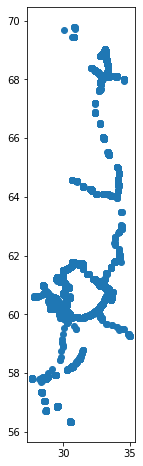

In [7]:
osm_gdf.plot(figsize=(8,8))

### Используем интерактивный вывод

Вызываем функцию `explore` пакета `geopandas`.
Видим, что точки ложаться на дороги и представляют, собственно говоря, отрезки кривых дорог.
Из за сложностей сохранения инетрактивной карты, я закомментровала вызов функции и вывела результат в виде сохранённой картинки.

In [11]:
# osm_gdf.explore(width='30%')

![RoadMap](img/explore.jpg)